# How to add smoothing and band-limits to optimized controls
**Incorporate smoothing of optimized waveforms**

Boulder Opal exposes a highly-flexible optimization engine for general-purpose gradient-based optimization.
It can be directly applied to model-based control optimization for arbitrary-dimensional quantum systems.
In general the optimizer will employ whatever freedom it is given, including infinite-bandwidth transitions between time-slices of a piecewise-constant signal.
However, such controls will not generally be faithfully reproduced on hardware, causing a challenge in realizing high-fidelity controls.
However, by incorporating smoothing into the optimization routine we can ensure that the outputs of an optimization are well reproduced in hardware.

In this user guide we introduce two different techniques for creating smooth or band-limited optimized controls: incorporating linear time-invariant filters into an optimization and using bounding slew rates in controls.
To learn the basics about control optimization, you can follow our [robust optimization tutorial](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs).

## Summary workflow

### 1. Define smoothing constraint in computational graph
The flexible [Boulder Opal optimization engine](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/run_optimization) expresses all optimization problems as data flow [graphs](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal), which describe how optimization variables (variables that can be tuned by the optimizer) are transformed into the cost function (the objective that the optimizer attempts to minimize).

In order to add smoothing you can pursue several different methods:

#### Filtering control signals
One can achieve tight frequency-domain control over the spectral content of a waveform using filtering.
The technique we use here is to pass the controls through a linear time-invariant filter in order to enforce explicit bandwidth limits.
To implement this behavior, we can create optimizable signals as usual, and then use the `graph.filter_and_resample_pwc` node to generate the filtered piecewise-constant (PWC) signal.

The effect of these filters is to transform the control signals before they reach the quantum system, via convolution with the filter impulse response.
Failing to take the filters into account during the optimization can lead to poor results, since in that case the system used for the optimization does not accurately model reality.

You can also additionally multiply the values of the signal by an envelope function that goes to zero at its extremities, which will effectively anchor the beginning and the end of the optimized pulse at zero.
Note, however, that depending on the functional form of the envelope, the banwidth of the optimized signal can go beyond the bandwidth limit set by the filter.

#### Bounding slew rates
A simple alternative is to constrain the rate of change of a signal between timesteps.
To implement a bounded slew rate, you create signal values using a Boulder Opal graph operation,
`graph.anchored_difference_bounded_variables`.
This function produces values that are constrained to satisfy the slew rate requirement, and in addition are anchored to zero at the start and end of the gate.


### 2. Run graph-based optimization

With the graph object created, an optimization can be run using the `boulderopal.run_optimization` function.
The cost, the outputs, and the graph must be provided.
The function returns the results of the optimization.
Note that this example code block uses naming that should be replaced with the naming used in your graph.

## Example: Smoothing control pulses using linear filters
    
In this section we present examples showing how linear time-invariant filters may be incorporated into an optimization.
To exemplify the use of filters, we consider a basic single-qubit system described by the Hamiltonian:

\begin{align*}
H(t) &= \frac{1}{2} \Omega(t) L(\alpha)(t) \sigma_{x} + \beta(t) \sigma_{z} , 
\end{align*}

where $\alpha(t)$ is a real time-dependent pulse,
$L$ is the filter applied to the pulse,
$\Omega(t)$ is an envelope fixing the pulse edges to zero,
and $\beta(t)$ is a small, slowly-varying stochastic dephasing noise process.

The effect of the filter is to transform the control signal before it reaches the quantum system, via convolution with the filter impulse response.


In this example, we use an in-built Boulder Opal function to produce the sinc filter to smooth the control pulse. Furthermore, we modulate the smoothed pulse with an envelope that enforces the final solution to start and end at zero. 
From the optimizations we output three sets of signals: the raw piecewise-constant signal, its smoothed version, and the final modulated signal.
The latter is the filtered signal that actually reaches the quantum system and performs the optimized gate. 

In [1]:
import numpy as np
import boulderopal as bo
from qctrlvisualizer import plot_controls

Your task (action_id="1827755") is queued.
Your task (action_id="1827755") has started.
Your task (action_id="1827755") has completed.
Optimized cost: 1.771e-11


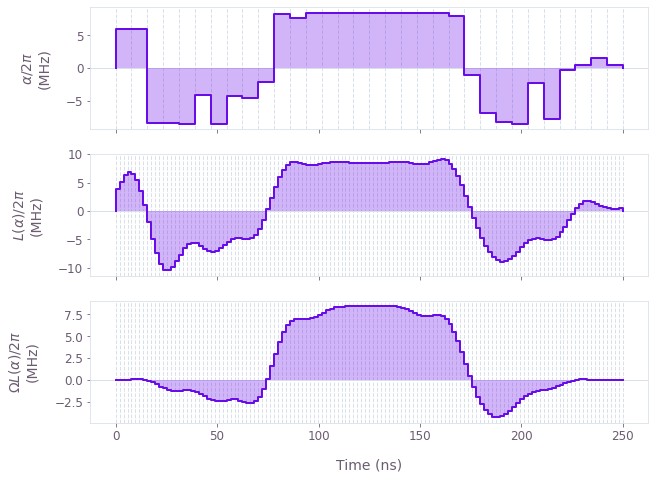

In [2]:
# Define physical constraints.
alpha_max = 2 * np.pi * 8.5e6  # rad/s
sinc_cutoff_frequency = 2 * np.pi * 48e6  # rad/s
optimizable_variable_count = 32
segment_count = 128
duration = 250e-9  # s

# Create graph object.
graph = bo.Graph()

# Create unfiltered signal.
unfiltered_alpha = graph.real_optimizable_pwc_signal(
    segment_count=optimizable_variable_count,
    duration=duration,
    maximum=alpha_max,
    minimum=-alpha_max,
    name="$\\alpha$",
)

# Filter signal.
rediscretized_alpha = graph.filter_and_resample_pwc(
    pwc=unfiltered_alpha,
    kernel=graph.sinc_convolution_kernel(sinc_cutoff_frequency),
    segment_count=segment_count,
    name="$L(\\alpha)$",
)

# Modulate signal with envelope.
envelope_signal = graph.signals.cosine_pulse_pwc(
    duration=duration, segment_count=segment_count, amplitude=1.0
)
alpha = envelope_signal * rediscretized_alpha
alpha.name = "$\\Omega L(\\alpha)$"

# Create control term.
control_term = alpha * graph.pauli_matrix("X") / 2

# Create dephasing noise term.
dephasing_term = graph.pauli_matrix("Z") / duration

# Create infidelity.
infidelity = graph.infidelity_pwc(
    hamiltonian=control_term,
    target=graph.target(graph.pauli_matrix("X")),
    noise_operators=[dephasing_term],
    name="infidelity",
)

# Run the optimization.
result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=["$\\alpha$", "$L(\\alpha)$", "$\\Omega L(\\alpha)$"],
    optimization_count=8,
)
print(f"Optimized cost: {result['cost']:.3e}")

# Visualize controls.
plot_controls(result["output"])

Unfiltered (top), filtered (center), and pinned (bottom) control amplitudes as a function of time.

## Example: Band-limited pulses with bounded slew rates

Next we show how to optimize a system in which the rates of change of the controls are limited.
Using this constraint can help to ensure that optimized controls can be reliably implemented on physical hardware (which may be subject to bandwidth limits).
We consider a standard single-qubit system subject to dephasing noise:

\begin{align*}
H(t) &= \frac{1}{2} \alpha_1(t)\sigma_{x} + \frac{1}{2} \alpha_2(t) \sigma_{z} + \beta(t) \sigma_{z} , 
\end{align*}

where $\alpha_1(t)$ and $\alpha_2(t)$ are real time-dependent pulse and $\beta(t)$ is a small, slowly-varying stochastic dephasing noise process.
In this case, we enforce a maximum slew rate constraint on $\alpha_1(t)$ and $\alpha_2(t)$, to cap the variation between adjacent segment values.

Your task (action_id="1827757") has started.
Your task (action_id="1827757") has completed.
Optimized cost: 2.107e-03


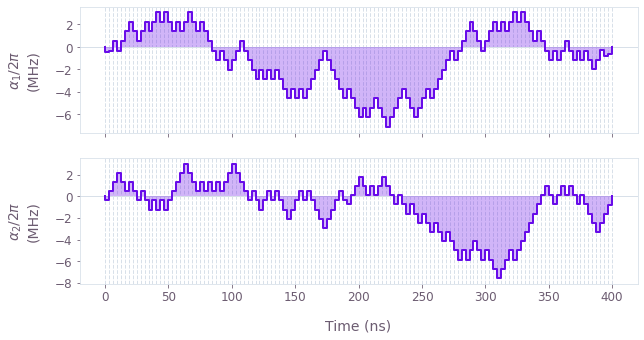

In [3]:
# Define physical constraints.
alpha_max = 2 * np.pi * 8.5e6  # rad/s
max_slew_rate = alpha_max / 10
segment_count = 128
duration = 400e-9  # s

# Create graph object.
graph = bo.Graph()

# Create signals.
alpha_1_values = graph.anchored_difference_bounded_variables(
    count=segment_count,
    lower_bound=-alpha_max,
    upper_bound=alpha_max,
    difference_bound=max_slew_rate,
)
alpha_1 = graph.pwc_signal(values=alpha_1_values, duration=duration, name="$\\alpha_1$")
alpha_2_values = graph.anchored_difference_bounded_variables(
    count=segment_count,
    lower_bound=-alpha_max,
    upper_bound=alpha_max,
    difference_bound=max_slew_rate,
)
alpha_2 = graph.pwc_signal(values=alpha_2_values, duration=duration, name="$\\alpha_2$")

# Create control Hamiltonian.
hamiltonian = (
    alpha_1 * graph.pauli_matrix("X") + alpha_2 * graph.pauli_matrix("Z")
) / 2

# Create dephasing noise term.
dephasing_term = graph.pauli_matrix("Z") / duration

# Create infidelity.
infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    target=graph.target(operator=graph.pauli_matrix("Y")),
    noise_operators=[dephasing_term],
    name="infidelity",
)

# Run the optimization.
result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=["$\\alpha_1$", "$\\alpha_2$"],
    optimization_count=20,
)
print(f"Optimized cost: {result['cost']:.3e}")

# Plot the optimized controls.
plot_controls(result["output"])

Pulse amplitudes obtained from a band-limited optimization with bounded-slew rates for $\alpha_1(t)$ (top) and $\alpha_2(t)$ (bottom).